# Norcom task: Dr. Giorgio Cortiana
Time Series Analysis
Extracting information from time series is a key goal in data science. SAX is a symbolic representation of time series that provides a particular promising approach to accomplish this (see, e.g., Sec. 2.3 in iSAX: Indexing and Mining Terabyte Sized Time Series, Jin Shieh & Eamonn Keogh, SIGKDD, 2008).

Your task is to familiarize yourself with the SAX concept. Then, please apply what you have learned and

1) generate a time series x(t), where t >= 0 and x are real numbers,

2) translate the time series into its symbolic representation using SAX, 

3) compute the frequency of each SAX symbol in this representation, 

4) locate the three most-frequent SAX symbols and

5) extract the corresponding numerical values in the time series x(t).

Time series can be tought of as a 1-dimensional representation of complex data: shape, DNA sequences...


In [1]:
# make sure plots will be added to the notebook
%matplotlib inline

# some imports
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# define a function to generate a pseudo time series
# add some random noise to it
rng = np.random.RandomState(2015)
def f(t):
    #return np.sin(t)+0.001*t*t+5*rng.uniform(size=len(t))-0.00001*t*t*t
    return 1+np.sin(t)+0.001*t*t+5*rng.uniform(size=len(t))
    

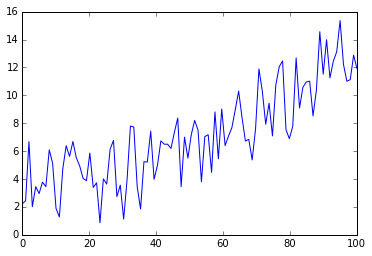

In [3]:
# let generate the time axis, 100 ptx from 0 to 100.
# then plot the function f(t).

datasetsize =100

X = np.linspace(0, datasetsize, datasetsize)
Y = f(X)
plt.plot(X, f(X))

Alternatively load data from some other source, example NC5A stock behaviour of the last few months. Example:
http://finance.yahoo.com/q/hp?s=NC5A.DE+Historical+Prices
table.csv

This will be the default in the following.

          Date   Open   High    Low  Close  Volume  Adj Close
0   2015-09-01  2.346  2.500  2.345  2.500    5000      2.500
1   2015-08-31  2.174  2.609  2.174  2.464   56700      2.464
2   2015-08-28  2.130  2.179  2.130  2.179    1200      2.179
3   2015-08-27  2.021  2.119  2.021  2.119       0      2.119
4   2015-08-26  2.119  2.119  2.119  2.119     100      2.119
5   2015-08-25  2.150  2.150  2.150  2.150       0      2.150
6   2015-08-24  2.181  2.309  2.010  2.119   27200      2.119
7   2015-08-21  2.211  2.279  2.181  2.279    1300      2.279
8   2015-08-20  2.249  2.285  2.249  2.285    1100      2.285
9   2015-08-19  2.181  2.181  2.180  2.180    1000      2.180
10  2015-08-18  2.239  2.239  2.239  2.239     200      2.239
11  2015-08-17  2.249  2.249  2.249  2.249     200      2.249
12  2015-08-14  2.279  2.279  2.279  2.279     100      2.279
13  2015-08-13  2.250  2.394  2.250  2.280   15200      2.280
14  2015-08-12  2.100  2.180  2.100  2.180    2000      2.180
15  2015

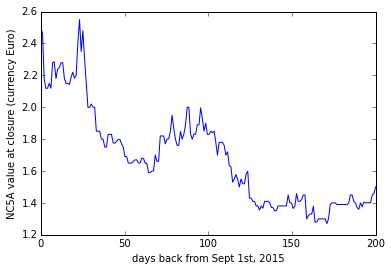

In [4]:
# load  NC5A stock data from file
import pandas as pd
filename = "table.csv"
data = pd.read_table(filename,sep=',')
print data[0:100]
# limit datasets to the last "datasetsize" days
datasetsize  =200
closuredata = data['Close'][0:datasetsize].values

# comment the following three lines to keep using the randomly generated dataset
Y = closuredata
X = np.linspace(0, datasetsize, datasetsize)


# plot the data.
plt.plot(X, closuredata)
plt.xlabel("days back from Sept 1st, 2015")
plt.ylabel("NC5A value at closure (currency Euro)")



Print out the mean and the standard deviation of the considered time series

In [5]:
Y.mean()

1.6870750000000001

In [6]:
Y.std()

0.30528270402202612

In [7]:
# define a normalization function. This is needed to better define the SAX breakpoints.
def normalize(t):
    X = np.asanyarray(t)
    return (X-X.mean())/X.std()


In [8]:
# normalize the time series, and print its mean and standard deviation 
Ynorm = normalize(Y)
print 'Ynorm mean' , Ynorm.mean()
print 'Ynorm std ' , Ynorm.std()

Ynorm mean -2.84217094304e-16
Ynorm std  1.0


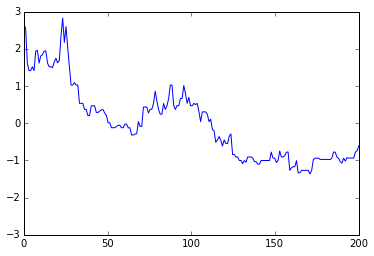

In [9]:
# plot the normalized time series
plt.ylim(-3.0,3.0)
plt.plot(X, Ynorm)
#

In [10]:
# once the data is normalized, the first step is to perform a PAA 
# (Piecewise Aggregate Approximatio)
# 
# function adapted from saxpy module:
# https://github.com/nphoff/saxpy
# changes: added wordsize as an argument to the function, move internal parameter and make 
#          them available globally

wordsize    =  25 # ie the number of PAA steps
cardinality =   8 # the number of symols to be used for the SAX representation

import math
def to_PAA(x, wordsize):
        """
        Funciton performs Piecewise Aggregate Approximation on data set, reducing
        the dimension of the dataset x to w discrete levels. returns the reduced
        dimension data set, as well as the indicies corresponding to the original
        data for each reduced dimension.
        """
        n = len(x)
        stepFloat = n/float(wordsize)
        step = int(math.ceil(stepFloat))
        frameStart = 0
        approximation = []
        indices = []
        i = 0
        while frameStart <= n-step:
            thisFrame = np.array(x[frameStart:int(frameStart + step)])
            approximation.append(np.mean(thisFrame))
            indices.append((frameStart, int(frameStart + step)))
            i += 1
            frameStart = int(i*stepFloat)
        return (np.array(approximation), indices)

In [11]:
# store the PAA values and the corresponidng indices, and print them
(paax,index) = to_PAA(Ynorm,wordsize)
print paax, "\n", index

[ 1.81487517  1.77925245  1.85827757  1.55937429  0.47226717  0.37932054
  0.00630563 -0.08131807 -0.11243677  0.48577924  0.48905489  0.64423892
  0.56644218  0.20612042 -0.402332   -0.65414777 -0.98335083 -1.02716268
 -0.96533474 -0.93257822 -1.22697747 -1.12092823 -0.96983876 -0.93380659
 -0.85109637] 
[(0, 8), (8, 16), (16, 24), (24, 32), (32, 40), (40, 48), (48, 56), (56, 64), (64, 72), (72, 80), (80, 88), (88, 96), (96, 104), (104, 112), (112, 120), (120, 128), (128, 136), (136, 144), (144, 152), (152, 160), (160, 168), (168, 176), (176, 184), (184, 192), (192, 200)]


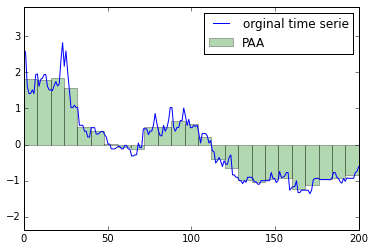

In [12]:
# plot the PAA result for the time series, and overlay this with the original time serie.
Xstep = np.linspace(0, datasetsize-(datasetsize/wordsize), wordsize)
binwidth= (X.max())/wordsize
plt.bar(Xstep,paax,binwidth,label='PAA',color='g',alpha=0.3)
plt.plot(X, Ynorm, label = "orginal time serie")
plt.ylim(Ynorm.min()-1,Ynorm.max()+1)
#plt.xlim(0,100)
plt.legend(loc='best')

In [13]:
# to check plt.plot options, uncomment the following line
#plt.plot?
#plt.bar?

In [14]:
# define the break points for the SAX implementation,
# such that the area under a N(0,1) Gaussian curve from Î²_i to Î²_i+1 = 1/cardinality 
breakpoints = {
    '2' : [0.00],
    '3' : [-0.43, 0.43],
    '4' : [-0.67, 0, 0.67],
    '5' : [-0.84, -0.25, 0.25, 0.84],
    '6' : [-0.97, -0.43, 0, 0.43, 0.97],
    '7' : [-1.07, -0.57, -0.18, 0.18, 0.57, 1.07],
    '8' : [-1.15, -0.67, -0.32, 0, 0.32, 0.67, 1.15]    
}
beta = breakpoints[str(cardinality)]


In [15]:
print cardinality, "\n", beta

8 
[-1.15, -0.67, -0.32, 0, 0.32, 0.67, 1.15]


In [16]:
# adapted from saxpy module:
def PAA2SAX(paaX):
    """
    Converts the Piecewise Aggregate Approximation of x to a series of letters.
    """
    alphabetizedX = ''
    aOffset = ord('a')
    for i in range(0, len(paaX)):
        letterFound = False
        for j in range(0, len(beta)):
            if paaX[i] < beta[j]:
                alphabetizedX += chr(aOffset + j)
                letterFound = True
                break
        if not letterFound:
            alphabetizedX += chr(aOffset + len(beta))
    return alphabetizedX


In [17]:
SAXword = str(PAA2SAX(paax))
print len(SAXword)
print SAXword

25
hhhhffeddffffeccbbbbabbbb


The next task consist in counting the occurrency of the various SAX symbols, the to retrive the three most recurring ones and the related original data.

Let us first count the number of occurencies of each symbol in the SAXword

In [18]:
# use Counter
# Dict subclass for counting hashable items.  Sometimes called a bag
# or multiset.  Elements are stored as dictionary keys and their counts
# are stored as dictionary values.
# See Counter? for more details

from collections import Counter
counter = Counter(SAXword)
print counter



Counter({'b': 8, 'f': 6, 'h': 4, 'c': 2, 'e': 2, 'd': 2, 'a': 1})


In [19]:
# get the three most common characters 
counter.most_common(3)

[('b', 8), ('f', 6), ('h', 4)]

The last task is to extract the original values of the time series according to these SAX symbols.

We do have the indexes of the data corresponding to the PAA. These could be used to extract back the original values.

Modify the PAA2SAX function to keep track of the indices as well.

In [20]:
# define a dictionary with the SAX symbols and the correspoinding indices 
# for the original dataset
indextoTS = {}
aOffset = ord('a')
for j in range(0, len(beta)):
    indextoTS[chr(aOffset + j)]=[]
indextoTS[chr(aOffset + len(beta))]=[]

def PAA2SAX(paaX):
    """
    Converts the Piecewise Aggregate Approximation of x to a series of letters.
    Store also the indices to allow for mapping to the original time series data.
    """
    alphabetizedX = ''    
    for i in range(0, len(paaX)):
        letterFound = False
        for j in range(0, len(beta)):
            if paaX[i] < beta[j]:
                alphabetizedX += chr(aOffset + j)
                letterFound = True
                for idx in range(index[i][0], index[i][1],1):
                    indextoTS[chr(aOffset + j)].append(idx)
                break
        if not letterFound:
            alphabetizedX += chr(aOffset + len(beta))
            for idx in range(index[i][0], index[i][1],1):
                indextoTS[chr(aOffset + len(beta))].append(idx)    
    return alphabetizedX
SAXword = str(PAA2SAX(paax))
print len(SAXword)
print SAXword
print indextoTS['b'] 

25
hhhhffeddffffeccbbbbabbbb
[128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


In [21]:
# save the key for the most common characters in the SAX representation
mc = counter.most_common(3)
print type(mc), mc

<type 'list'> [('b', 8), ('f', 6), ('h', 4)]


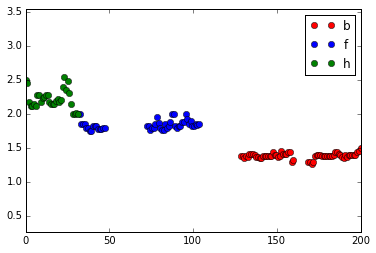

In [22]:
# retrive the original time series values for the most common characters
# plot the corresponding values in a graph

for j in range(0,3,1):
    mcl = []
    for i in indextoTS[mc[j][0]]:
        mcl.append(Y[i])
    mcla = np.asarray(mcl)
    mclax = np.asarray(X[indextoTS[mc[j][0]]])
    plt.xlim(0,datasetsize)
    plt.ylim(Y.min()-1, Y.max()+1)
    if j==0:
        plt.plot(mclax, mcla,'ro', label=mc[j][0])
    elif j==1:
        plt.plot(mclax, mcla,'bo', label=mc[j][0])
    else:
        plt.plot(mclax, mcla,'go', label=mc[j][0])

plt.legend(loc='best')
